In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

### Funcioncitas

In [ ]:
def broadcast_1darray(a:np.ndarray, times):
    a_broad = np.repeat(a.squeeze()[:, np.newaxis], times, axis=1)
    return a_broad

In [ ]:
def broadcast_0darray(a:np.ndarray, times_x, times_y):
    a = np.repeat(a[:, np.newaxis], times_x, axis=0)
    a = np.repeat(a[:, np.newaxis], times_y, axis=1).squeeze()
    return a

In [ ]:
def calculate_weighted_matrix_multiplication(W:np.ndarray, M_1: np.ndarray, M_2: np.ndarray):
    a = M_1.shape[1]
    WM_1 = W[:a,a:]@M_1.transpose()
    WM_1M_2 = WM_1.transpose()@M_2.transpose()
    return WM_1M_2

In [ ]:
def calculate_linear_weighted_features(M: np.ndarray, w: np.ndarray):
    """ Calcula Suma(i=1, a)wi Uui"""
    if M.shape[1] != w.shape[0]:
        raise Exception("calculate_linear_weighted_features: las matrices no se pueden multiplicar. Chequear la dimension.")
    else:
        return (M@w.reshape(-1,1))

In [ ]:
def calculate_weighted_interactions(M: np.ndarray, W: np.ndarray):
    """ Calcula las interacciones de cada fila de M ponderadas con W.
    Es una implementacion de la siguiente formula
    Suma(i=1, a-1)Suma(j=i+1, a) W_ij Uui Uuj
    """
    if M.shape[1]!=W.shape[0]:
        raise Exception("calculate_weighted_interactions: Las matrices M y W no se pueden multiplicar.")
    if W.shape[0]!=W.shape[1]:
        raise Exception("calculate_weighted_interactions: La matriz de pesos no es cuadrada.")
    
    M_interactions = calculate_interactions(M)
    upper_W = get_upper_triangle_matrix(W)
    M_weighted_interactions = (M_interactions@upper_W).reshape(-1,1)
    return M_weighted_interactions

In [ ]:
def get_upper_triangle_matrix(M: np.ndarray):
    """Devuelve los elementos de la triangular superior sin la diagonal. 
    Esos elementos se aplastar a un array 1D
    Si M es la matriz de 3x3
    1 2 3
    4 5 6
    7 8 9
    La salida es el array [2,3,6]
    """
    if (M.shape[0]!=M.shape[1]):
       raise Exception("get_upper_triangle_matrix: La matriz no es cuadrada")
    else:
        out_size = M.shape[0]
        return M[np.triu_indices(out_size, k = 1)]

In [ ]:
def calculate_interactions(M: np.ndarray):
    interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
    M_interactions = interaction.fit_transform(M)
    M_interactions = M_interactions[:,M.shape[1]:] # Me quedo unicamente con las interacciones de tipo xy, xz, yz
    return M_interactions

### Proto Recomendador
Esta notebook está basada en el paper A Recommendation Model Based on Deep Neural Network del autor LIBO ZHANG

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
n_users = 50
n_items = 100
# TODO: Si a no es igual a b se rompe. Ver por qué
a = 20
b = 20
l = a + b

ratings = np.random.randint(0, 2, n_users*n_items).reshape(n_users,n_items)

### Inicializo algunos pesos

In [ ]:
W = np.random.rand(l,l)
w = np.random.rand(l)

U = np.random.rand(n_users, a)
V = np.random.rand(n_items, b)

In [ ]:
p = calculate_linear_weighted_features(U,w[:a]) + 0*calculate_weighted_interactions(U, W[:a,:a])
p.shape

In [ ]:
q = calculate_linear_weighted_features(V,w[a:]) + 0*calculate_weighted_interactions(V,W[a:,a:])
q.shape

In [ ]:
z = np.random.rand(1)
z_broad = broadcast_0darray(z, times_x=n_users, times_y=n_items).shape

### Entrenamiento Regresión Cuadrática

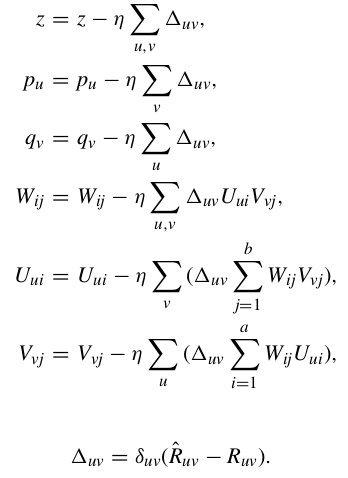

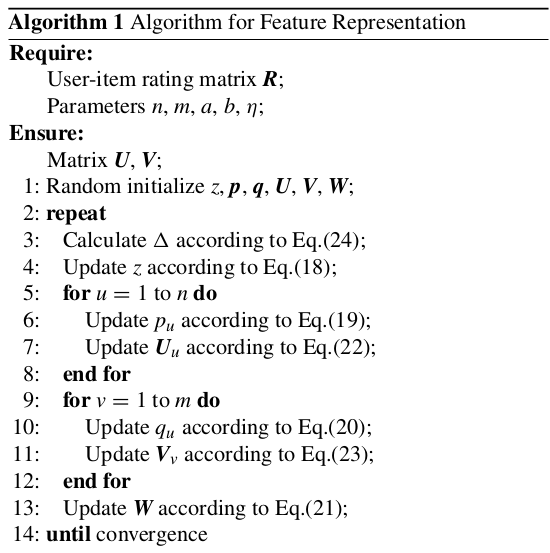

In [ ]:
lr = 0.01
loss_tracker = []
epochs = 1000000

In [ ]:
L_anterior = 0
L_nuevo = 0

for i in range(epochs):
    L_anterior = L_nuevo
    # Forward Pass
    p_broad = broadcast_1darray(p, times = n_items)
    q_broad = broadcast_1darray(q, times = n_users).transpose()
    z_broad = broadcast_0darray(z, times_x=n_users, times_y=n_items)
    R_uv = z_broad + p_broad + q_broad + calculate_weighted_matrix_multiplication(W,U,V)
    L_nuevo = (((ratings-R_uv)*(ratings-R_uv)).mean())/2
    L_diferencia = L_anterior - L_nuevo
    
    mae = (np.absolute(ratings-R_uv)).mean()

    if (i%50==0):
        print("Epoch {} Loss: {}  MAE: {}".format(i, L_nuevo, mae), end = "\r")
    if (i%100==0):
        loss_tracker.append(L_nuevo)

    if (L_diferencia < 0.0000001)&(i>100):
        print("\nEarly stopping en epoch {}".format(i))
        break

    delta_uv = (R_uv-ratings)
    # Update z
    z = z - lr*(delta_uv.mean())
    # Update p
    p = p - lr*(delta_uv.mean(axis=1).reshape(n_users,-1))
    #print("p: \n{}".format(p))
    # Update q
    q = q - lr*(delta_uv.mean(axis=0).reshape(n_items,-1))
    # Update U
    U = U - lr * (delta_uv@(W[:a,a:]@V.transpose()).transpose())/(n_items*b)
    # Update V
    V = V - lr * ((W[:a,a:]@U.transpose())@delta_uv).transpose()/(n_users*a)
    # Update W (O la parte de W que se va a usar)
    W[:a,a:] = W[:a,a:] - lr * ((delta_uv.transpose()@U).transpose()@V)/(n_users*n_items)

In [ ]:
q_broad = broadcast_1darray(q, times = n_users).transpose()
q_broad.shape

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0,len(loss_tracker)*100, 100)[1:]
y = loss_tracker[1:]

plt.plot(x, y, linewidth=2)
plt.grid(alpha=.4)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [ ]:
# Vemos algunas predicciones vs la realidad
ratings[:4,0:4], R_uv[0:4,0:4]

In [ ]:
# Si redondeamos la predicción al entero más cercano podemos calcular el accuracy
acc = 1-np.absolute(np.rint(R_uv)-ratings).mean()
print("Accuracy: {}".format(acc))